In [1]:
import kagglehub
import os
import shutil

downloaded_path = kagglehub.dataset_download("arnaudeq/cats-vs-dogs-1000")
target_dir = '/content/data'
os.makedirs(target_dir, exist_ok=True)
for file_name in os.listdir(downloaded_path):
    shutil.move(os.path.join(downloaded_path, file_name), target_dir)

print(f"Dataset moved to: {target_dir}")

100%|██████████| 177M/177M [00:01<00:00, 129MB/s]

Extracting files...


Dataset moved to: /content/data


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models,transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.486,0.450,0.425],
        std = [0.245,0.229,0.225]
    )
])

train_dataset = ImageFolder(
    root="data/dogs_cats_sample_1000/train",
    transform=transform
)
test_dataset = ImageFolder(
    root="data/dogs_cats_sample_1000/train",
    transform=transform
)
print(train_dataset.classes)

['cats', 'dogs']


In [3]:
## Feature Extraction (Frozen Backbone)
model = models.resnet18(pretrained=True)
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features,num_classes)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


In [4]:
total_params = 0
trainable_params = 0

for name, param in model.named_parameters():
    total_params += param.numel()
    if param.requires_grad:
        trainable_params += param.numel()

print(f"\nTotal params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")



Total params: 11,177,538
Trainable params: 11,177,538


In [5]:
for param in model.parameters():
  param.requires_grad = False

for param in model.fc.parameters():
  param.requires_grad  = True

total_params = 0
trainable_params = 0

for name,param in model.named_parameters():
  total_params+=param.numel()
  if param.requires_grad:
    trainable_params += param.numel()

print(f"Total parameters:: {total_params:,}")
print(f"Trainabale parameters:: {trainable_params:,}")

Total parameters:: 11,177,538
Trainabale parameters:: 1,026


In [7]:
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10

train_loader = DataLoader(dataset=train_dataset,shuffle=True,num_workers=2,batch_size=64,pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,shuffle=False,num_workers=2,batch_size=64,pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
  # ------TRAINING------
  train_loss = 0
  train_correct = 0
  train_total = 0

  model.train()
  for images,labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    loss = criterion(logits,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss+=loss.item()


    _,predicted = torch.max(logits,1)
    train_total+= labels.size(0)
    train_correct+= (predicted==labels).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100*train_correct / train_total


# -----------VALIDATION---------
  model.eval()
  val_loss = 0
  val_correct = 0
  val_total = 0

  for images,labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    logits = model(images)
    loss = criterion(logits,labels)

    val_loss+=loss.item()
    val_total+=labels.size(0)
    _,predicted = torch.max(logits,1)
    val_correct+= (predicted==labels).sum().item()

  val_loss /= len(test_loader)
  val_accuracy = 100*val_correct / val_total

  if(epoch%1==0):
    print(f"Epoch({epoch+1}/{epochs},)")
    print(f"Training_loss = {train_loss}")
    print(f"Training_accuracy = {train_accuracy}")
    print(f"Validation_loss = {val_loss}")
    print(f"Validation_accuracy = {val_accuracy}")
    print("----------------")



Epoch(1/10,)
Training_loss = 0.14958886965177953
Training_accuracy = 95.35
Validation_loss = 0.11011189711280167
Validation_accuracy = 96.0
----------------
Epoch(2/10,)
Training_loss = 0.10616711829788983
Training_accuracy = 96.65
Validation_loss = 0.0862271694932133
Validation_accuracy = 97.8
----------------
Epoch(3/10,)
Training_loss = 0.09629138349555433
Training_accuracy = 97.05
Validation_loss = 0.07892122311750427
Validation_accuracy = 97.9
----------------
Epoch(4/10,)
Training_loss = 0.08585199021035805
Training_accuracy = 96.85
Validation_loss = 0.06753144651884213
Validation_accuracy = 97.8
----------------
Epoch(5/10,)
Training_loss = 0.0846724160364829
Training_accuracy = 96.85
Validation_loss = 0.05633494787616655
Validation_accuracy = 98.25
----------------
Epoch(6/10,)
Training_loss = 0.08178506570402533
Training_accuracy = 97.0
Validation_loss = 0.0528118135407567
Validation_accuracy = 98.4
----------------
Epoch(7/10,)
Training_loss = 0.07733521977206692
Training_acc

In [8]:
## Fine-Tuning (Unfreezing layer4)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models,transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.486,0.450,0.425],
        std = [0.245,0.229,0.225]
    )
])

train_dataset = ImageFolder(
    root="data/dogs_cats_sample_1000/train",
    transform=transform
)
test_dataset = ImageFolder(
    root="data/dogs_cats_sample_1000/train",
    transform=transform
)

model = models.resnet18(pretrained=True)

num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features,num_classes)
for params in model.parameters():
    params.requires_grad = False

for params in model.layer4.parameters():
    params.requires_grad = True

for params in model.fc.parameters():
    params.requires_grad = True

total_params = 0
trained_params = 0

for names,params in model.named_parameters():
    total_params+= params.numel()
    if params.requires_grad:
        trained_params+=params.numel()
        print(f"Trainable: {names}")

print(f"Total parameters:: {total_params}")
print(f"Trainable parameters:: {trained_params}")









Trainable: layer4.0.conv1.weight
Trainable: layer4.0.bn1.weight
Trainable: layer4.0.bn1.bias
Trainable: layer4.0.conv2.weight
Trainable: layer4.0.bn2.weight
Trainable: layer4.0.bn2.bias
Trainable: layer4.0.downsample.0.weight
Trainable: layer4.0.downsample.1.weight
Trainable: layer4.0.downsample.1.bias
Trainable: layer4.1.conv1.weight
Trainable: layer4.1.bn1.weight
Trainable: layer4.1.bn1.bias
Trainable: layer4.1.conv2.weight
Trainable: layer4.1.bn2.weight
Trainable: layer4.1.bn2.bias
Trainable: fc.weight
Trainable: fc.bias
Total parameters:: 11177538
Trainable parameters:: 8394754


In [23]:
optimizer = optim.Adam([
    {'params':model.layer4.parameters(),'lr':1e-4},
    {'params':model.fc.parameters(),'lr':5e-4}
])

criterion = nn.CrossEntropyLoss()

epochs = 4

train_loader = DataLoader(dataset=train_dataset,shuffle=True,num_workers=2,batch_size=64,pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,shuffle=False,num_workers=2,batch_size=64,pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


train_acc_list,val_acc_list = [],[]
for epoch in range(epochs):
  train_total = 0
  train_loss = 0
  train_correct = 0
  model.train()

  for images,labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    logits = model(images)
    loss = criterion(logits,labels)
    train_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _,prediction = torch.max(logits,1)
    train_total+=labels.size(0)
    train_correct+=(prediction==labels).sum().item()

  train_loss /= len(train_loader)
  train_acc = 100*train_correct / train_total

  model.eval()
  val_loss = 0
  val_total = 0
  val_correct = 0
  with torch.no_grad():
    for images,labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      logits = model(images)
      loss = criterion(logits,labels)
      val_loss+=loss.item()

      _,prediction = torch.max(logits,1)
      val_total+=labels.size(0)
      val_correct+=(prediction==labels).sum().item()

  val_loss /= len(test_loader)
  val_acc = 100*val_correct / val_total

  train_acc_list.append(train_acc)
  val_acc_list.append(val_acc)
  if(epoch%1==0):
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Training Loss {train_loss}")
    print(f"Training accuracy {train_acc}")
    print(f"Validation Loss {val_loss}")
    print(f"Validation accuracy {val_acc}")
    print(f"----------------")






Epoch 1/4
Training Loss 0.002382690246982788
Training accuracy 99.9
Validation Loss 3.594745846463576e-06
Validation accuracy 100.0
----------------
Epoch 2/4
Training Loss 0.003955600901414336
Training accuracy 99.8
Validation Loss 3.1451449833928835e-05
Validation accuracy 100.0
----------------
Epoch 3/4
Training Loss 0.000646513607848398
Training accuracy 100.0
Validation Loss 1.1277636485229614e-05
Validation accuracy 100.0
----------------
Epoch 4/4
Training Loss 0.0008229568664432918
Training accuracy 100.0
Validation Loss 6.002448892532264e-06
Validation accuracy 100.0
----------------


In [12]:
torch.save(model.state_dict(), "resnet18_finetuned_dogsvscat.pth")


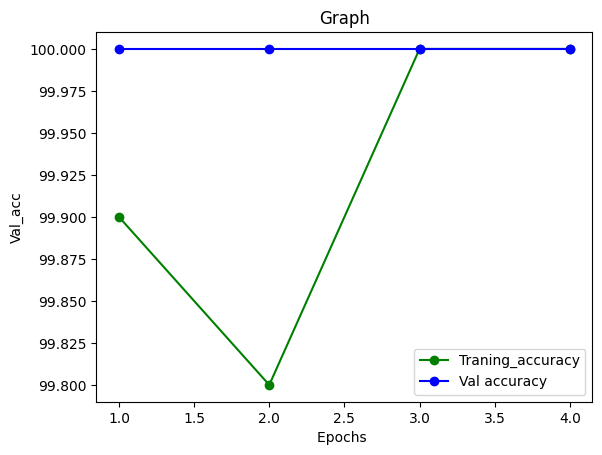

In [24]:
import matplotlib.pyplot as plt

epoch_range = range(1,len(train_acc_list)+1)

plt.plot(epoch_range,train_acc_list,marker='o',label=["Traning_accuracy"],color="Green")
plt.plot(epoch_range,val_acc_list,marker='o',label=["Val accuracy"],color="blue")
plt.legend()
plt.xlabel("Epochs ")
plt.ylabel("Val_acc")
plt.title("Graph")
plt.show()